## References
- Unsloth: [Website](https://unsloth.ai/)


In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [2]:
import torch
from unsloth import FastVisionModel
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from transformers import TextStreamer
from datasets import load_dataset



🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit quantization to reduce memory usage. Can be False.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2024.11.10: Fast Mllama vision patching. Transformers: 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/385k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [4]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,

    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)


## Data preparation


In [5]:
dataset = load_dataset("JerryMo/image-caption-blip-for-training", split = "train")

README.md:   0%|          | 0.00/420 [00:00<?, ?B/s]

(…)-00000-of-00001-706a830c55b95091.parquet:   0%|          | 0.00/113M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2485 [00:00<?, ? examples/s]

### See what the first image is, and what caption it had.

In [6]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 2485
})

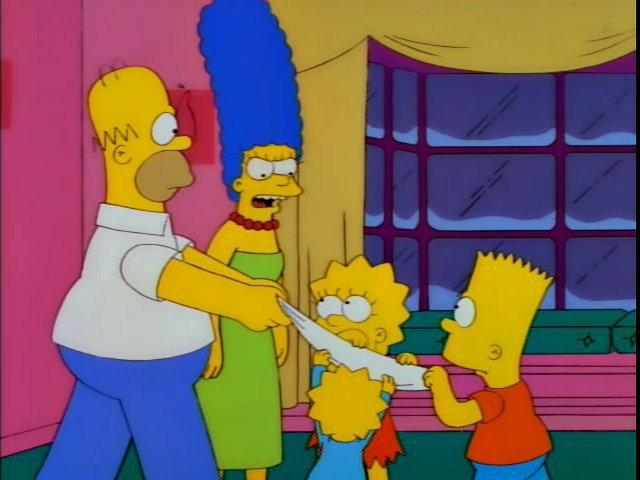

In [7]:
dataset[0]["image"]

In [8]:
dataset[0]["text"]

'a family scene in the simpsons animated tv, The Simpsons'

In [9]:
instruction = "You are an expert cartoonist. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

# Convert the dataset into the "correct" format for finetuning:

In [10]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

 How the conversations are structured for the first example:

In [11]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert cartoonist. Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'a family scene in the simpsons animated tv, The Simpsons'}]}]}

## Try the base model

In [12]:
FastVisionModel.for_inference(model)
image = dataset[0]["image"]
instruction = "You are an expert cartoonist. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")


text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This image depicts Homer Simpson brandishing an antique bread knife and menacingly pulling his children closer. He is positioned to the left, wearing his familiar attire: a white T-shirt, blue pants, and an open-mouthed look of aggression, as if his lips have been stitched together.

Marge Simpson, resplendent in a green dress and blue hair, stands between Homer and the children, looking perturbed but not intervening. Lisa Simpson, in a blue dress and sporting her characteristic pigtails adorned with red barrettes, stands in the middle, seemingly trying to shield her younger sibling. Bart Simpson, clad in a red t



## Train the model


In [13]:
FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [14]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
8.479 GB of memory reserved.


In [15]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,485 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 67,174,400
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,4.604600
2,4.651800
3,4.669300
4,4.938900
5,4.679400
6,4.146400


Step,Training Loss
1,4.604600
2,4.651800
3,4.669300
4,4.938900
5,4.679400
6,4.146400
7,3.428200
8,2.923000
9,2.486900
10,1.886400


In [16]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

934.6955 seconds used for training.
15.58 minutes used for training.
Peak reserved memory = 10.324 GB.
Peak reserved memory for training = 1.845 GB.
Peak reserved memory % of max memory = 70.003 %.
Peak reserved memory for training % of max memory = 12.51 %.



## Inference
.

In [17]:

FastVisionModel.for_inference(model)
image = dataset[0]["image"]
instruction = "You are an expert cartoonist. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

a family in front of their home, The simpsons<|eot_id|>



### Saving & loading finetuned model.


In [18]:
model.save_pretrained("finetuned_llama_3_2_vision") # Local saving
tokenizer.save_pretrained("finetuned_llama_3_2_vision")


[]

In [19]:
import wandb

wandb.init(project="finetuned_llama_3_2_V_Image_Caption", entity="Olfat")

model.save_pretrained("finetuned_llama_3_2_vision")
artifact = wandb.Artifact("finetuned_llama_3_2_V_Image_Caption", type="model")
artifact.add_dir("finetuned_llama_3_2_vision")
wandb.log_artifact(artifact)

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Adding directory to artifact (./finetuned_llama_3_2_vision)... Done. 1.5s


In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "finetuned_llama_3_2_vision",
        load_in_4bit = load_in_4bit,
    )
    FastVisionModel.for_inference(model)

image = dataset[0]["image"]
instruction = "You are an expert cartoonist. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

### Saving to float16 for VLLM



In [21]:
# Save locally to 16bit
if False: model.save_pretrained_merged("finetuned_llama_3_2_vision", tokenizer,)
